# HW10, Assignment 2 - Spatial Data Analysis
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

#### This is a lab prepared by Dr. Kashuk. Except where specified by a comment, code is as provided in the lab. Explanatory captions for plots are provided by Sofiya Elyukin, and some variables were renamed for better clarity.

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

## Import initial libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt

## Access the data within the notebook

In [ ]:
# Addition to notebook from se1296

# CitiBike Station Locations
!curl -O "https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/Station_id.csv"

# Monthly CitiBike Usage
!curl -O "https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/CitiBike_monthly_byStation.csv"

# 2010 Census Data
!curl -O "https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/ACS_CT2010.csv"

# Census Tract 2010 Shapefiles
!curl -O "https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/CT_Shape/ct_shape.cpg"
!curl -O "https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/CT_Shape/ct_shape.dbf"
!curl -O "https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/CT_Shape/ct_shape.shp"
!curl -O "https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/CT_Shape/ct_shape.prj"
!curl -O "https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/CT_Shape/ct_shape.shx"
!curl -O "https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data/CT_Shape/R10_BoroCT2010.csv"

## Working with Shape File

### Loading Census Tract Shape File¶

In [2]:
from geopandas import GeoDataFrame
shape_path="ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path) # this is the shapefile
ct_shape.index=ct_shape.BoroCT2010 # the census tract is now the index, this will allow joining datasets later

### Coordinate systems, projections, and transformations 

In [3]:
from fiona.crs import from_epsg
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

In [4]:
# se1296 adding code to spruce up plot, 
# http://matplotlib.org/users/legend_guide.html
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='Manhattan')
green_patch = mpatches.Patch(color='green', label='Bronx')
orange_patch = mpatches.Patch(color='orange', label='Brooklyn')
brown_patch = mpatches.Patch(color='brown', label='Queens')
gray_patch = mpatches.Patch(color='gray', label='Staten Island')

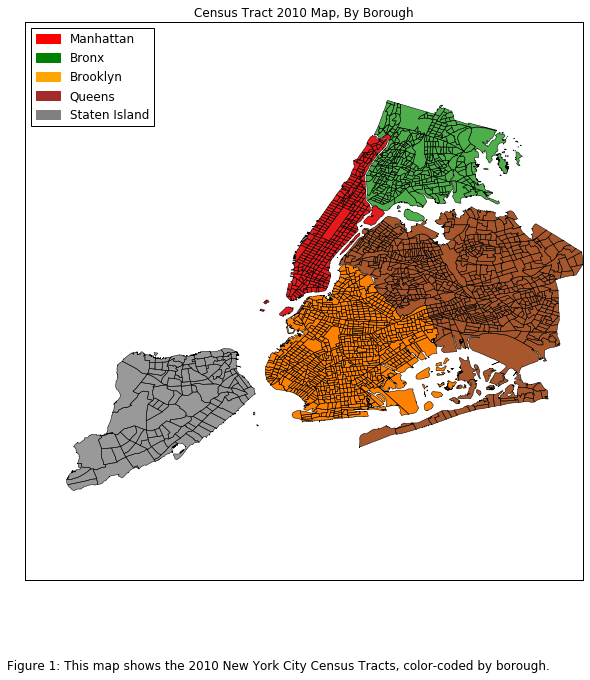

In [5]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax) 
plt.title("Census Tract 2010 Map, By Borough")
plt.legend(handles=[red_patch, green_patch, orange_patch, brown_patch, gray_patch], loc='upper left') #se1296
plt.figtext(0.1, -0.00001, '''Figure 1: This map shows the 2010 New York City Census Tracts, color-coded by borough.''',
            fontsize='large') #se1296

### Map NYC Population density

#### Load Census Data for 2010

In [6]:
ct_data=DataFrame.from_csv('ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [7]:
# with "join" you don't specify a column like for merge. it joins based on index
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Vusualize the Population density for 2010

/opt/rh/anaconda/root/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


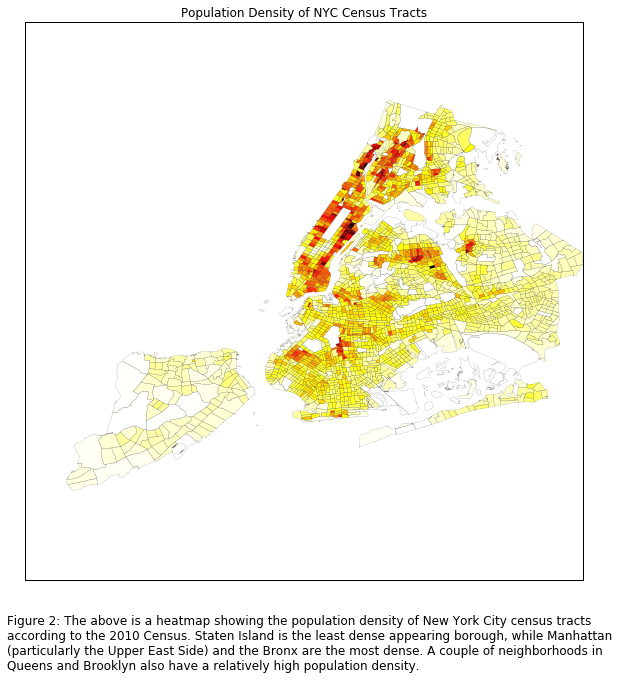

In [8]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density of NYC Census Tracts")
plt.figtext(0.1, -0.00001, '''Figure 2: The above is a heatmap showing the population density of New York City census tracts
according to the 2010 Census. Staten Island is the least dense appearing borough, while Manhattan
(particularly the Upper East Side) and the Bronx are the most dense. A couple of neighborhoods in
Queens and Brooklyn also have a relatively high population density.''',
            fontsize='large') #se1296

## Explore CitiBike data

### Load CitiBike data

In [9]:
df_bike_monthly=DataFrame.from_csv('CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


### Time Series Aanalysis

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


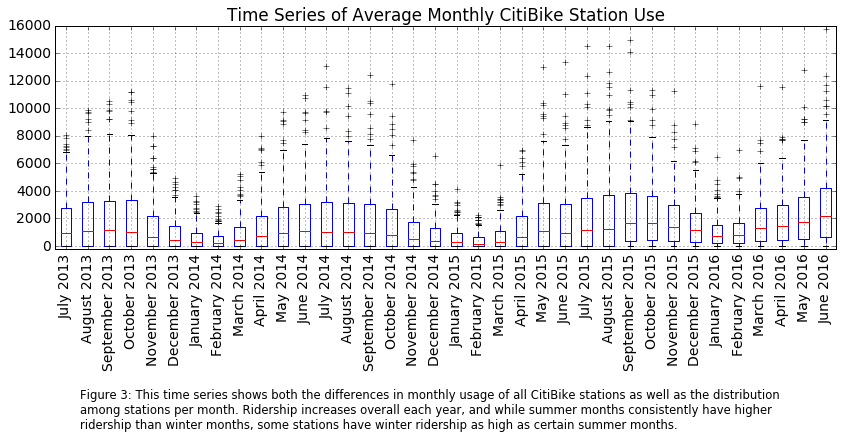

In [10]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_monthly_=df_bike_monthly.copy()
df_bike_monthly_.index=df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])
plt.title('Time Series of Average Monthly CitiBike Station Use')
plt.figtext(0.15, -.5, '''Figure 3: This time series shows both the differences in monthly usage of all CitiBike stations \
as well as the distribution
among stations per month. Ridership increases overall each year, and while summer months consistently have higher
ridership than winter months, some stations have winter ridership as high as certain summer months.''',
            fontsize='small') #se1296

#### Seasonal Decomposition

/opt/rh/anaconda/root/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


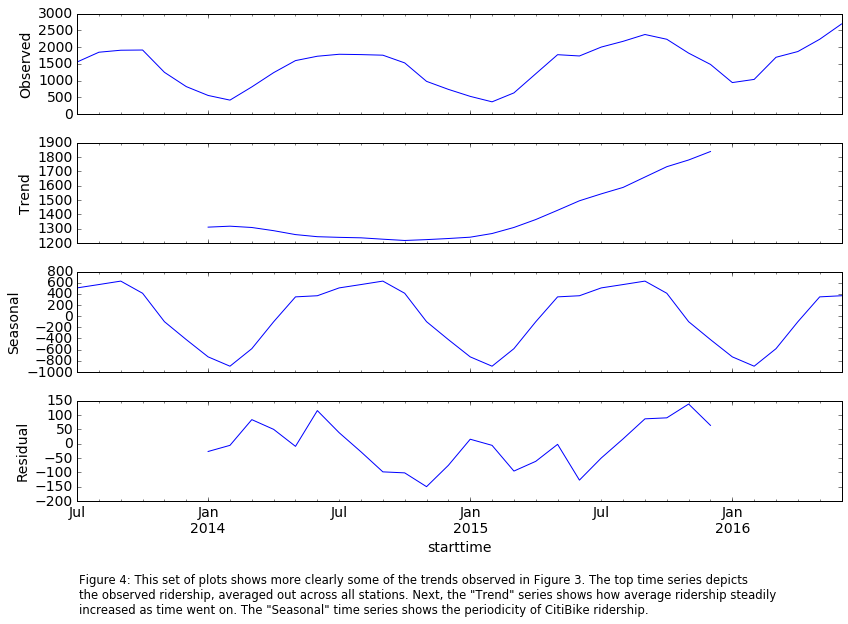

In [15]:
import statsmodels.api as sm

#Create a monthly time series of bike ride (Average of all citibike stations)
df_monthly_avg=df_bike_monthly.mean(1).resample('M').mean()
df_monthly_avg.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_monthly_avg.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot() #this is all 4 graphs
plt.figtext(0.1, -0.08, '''Figure 4: This set of plots shows more clearly some of the trends observed in Figure 3. \
The top time series depicts 
the observed ridership, averaged out across all stations. Next, the "Trend" series shows how average ridership steadily
increased as time went on. The "Seasonal" time series shows the periodicity of CitiBike ridership.''',
            fontsize='small') #se1296

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [16]:
station_id=DataFrame.from_csv('Station_id.csv')
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [17]:
import shapely
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [18]:
CTcodes=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    CTcodes.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4], 
station_id['BoroCT2010']=CTcodes

% 100.


In [19]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

##### se1296 note for comprehension: the above code functioned as a "spatial join". The station geometries were intersected with the census tract geometries, and for each station a value of TRUE was returned for the one and only tract whose geometry the station fell within. The code for that tract was then appended into a new column in the station_id dataframe.

### Add Monthly rides to the station GeoDataFrame with CT code
The code in this section is mine

#### First, separate winter and summer months

In [57]:
bike_summer = df_bike_monthly[(df_bike_monthly.index.month > 3) & (df_bike_monthly.index.month < 10)]
bike_winterA = df_bike_monthly[(df_bike_monthly.index.month < 4)]
bike_winterB = df_bike_monthly[(df_bike_monthly.index.month > 9)]
bike_winter = bike_winterA.append(bike_winterB)

In [49]:
bike_winter.sort_index(inplace=True)

In [65]:
print len(bike_summer), len(df_bike_monthly), len(bike_winter)
bike_winter.head()

18 36 18


,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-10-31,2920,4409.0,10456,3520,8928,3237,2530,3909,4169.0,2542,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-11-30,1883,2731.0,6384,2446,5201,2085,1415,2727,3146.0,1539,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-12-31,1299,1650.0,4081,1686,3046,1575,830,1890,2048.0,1009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-31,956,1337.0,3178,1251,1920,1130,477,1412,1082.0,681,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-28,650,960.0,2920,676,1808,933,508,1045,963.0,530,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Check type for stations that didn't exist in certain months
#bike_summer.head()
#type(bike_summer['1533'][3])

In [55]:
# From HW9 --> change values to NaN to leave out of aggregation
#bike_summer = MTArides.astype(np.float, copy = False)
bike_winter[bike_winter == 0] = np.nan
#bike_winter.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-10-31,2920,4409.0,10456,3520,8928,3237,2530,3909,4169.0,2542,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-11-30,1883,2731.0,6384,2446,5201,2085,1415,2727,3146.0,1539,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-12-31,1299,1650.0,4081,1686,3046,1575,830,1890,2048.0,1009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-31,956,1337.0,3178,1251,1920,1130,477,1412,1082.0,681,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-28,650,960.0,2920,676,1808,933,508,1045,963.0,530,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
bike_summer[bike_summer == 0] = np.nan
#bike_summer.head()

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914.0,6979,2750,4914,2229,2183,3139,3622.0,2368,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-31,2696,4429.0,9020,3433,6645,2768,2761,3422,4271.0,2910,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-09-30,2878,5258.0,9814,3739,7837,3206,2747,3590,4618.0,2885,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-04-30,1319,2315.0,7056,2371,4479,2266,1417,3288,3000.0,1540,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-31,1696,3125.0,9070,3115,6207,2897,2049,3579,3863.0,2062,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['WinterMonthlyAve']=bike_winter.
station_id['SummerMonthlyAve']=bike_summer.

In [ ]:
station_id.head()

### Add the monthly average rides to the CT shapefile 

In [ ]:
# use the 
temp=station_id[['MonthlyAve']]
temp['station_id']=station_id.index
temp.index=station_id['BoroCT2010']
ct_shape_MonthlyAve=ct_shape.join(temp)
ct_shape_MonthlyAve.fillna(0,inplace=True)

In [ ]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAve.plot(column='MonthlyAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Monthly Ride Counts")

### Removing the CTs that are out of zoom boundries

In [ ]:
ct_shape_MonthlyAve_Zoom=(ct_shape_MonthlyAve[ct_shape_MonthlyAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [ ]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp.MonthlyAve)

### Map the monthly rides 

In [ ]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom.plot(column='MonthlyAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Monthly Ride Counts")

### Export Shapefile CTs in the CitiBike Zone

In [ ]:
path='Output/ct_shape_MonthlyAve_Zoom.shp'
ct_shape_MonthlyAve_Zoom.to_file(path)

## Exploratory Geospatial Analysis

In [ ]:
import pysal as ps

### Spatial Weights
Contiguity: Queen Weights

In [ ]:
qW_CT=ps.queen_from_shapefile(path)

#### Neighbors of index10

In [ ]:
qW_CT[10]
qW_CT

In [ ]:
qW_CT.cardinalities[10] # how many neighbors (i.e. count above output)

#### Matrix of Weights

In [ ]:
Wmatrix, ids = qW_CT.full()

In [ ]:
Wmatrix

#### Change the matrix to be row-standardized

In [ ]:
qW_CT.transform = 'r'

### Spatial Lag  
Similarity of CT neighbors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [ ]:
MonthlyRide=ct_shape_MonthlyAve_Zoom.MonthlyAve
MonthlyRideLag=ps.lag_spatial(qW_CT, MonthlyRide)

#### Create Quantiles for maping

In [ ]:
MonthlyRideLagQ10 = ps.Quantiles(MonthlyRideLag, k=10)
MonthlyRideLagQ10

#### Map the monthly rides lag

In [ ]:
# This map is pointless? --> can't interpret it yet. The current color value of each tract is a representation of its neighbors,
# not itself. I.e., if tract has high value, it just means its neighbors have a high value
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=MonthlyRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Monthly Ride Spatial Lag Deciles")
# gov island and the piers are the same census tract, that's why it has neighbors

## Global  Spatial Autocorrelation

In [ ]:
b,a = np.polyfit(MonthlyRide, MonthlyRideLag, 1)
b,a 

### Moran Scatterplot

In [ ]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(MonthlyRide, MonthlyRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide.mean(), MonthlyRideLag.min(), MonthlyRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag.mean(), MonthlyRide.min(), MonthlyRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide, a + b*MonthlyRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')

### Moran's I

In [ ]:
I_MonthlyRide = ps.Moran(MonthlyRide, qW_CT) #using pysal   #click inside here, then press shift+tab

In [ ]:
I_MonthlyRide.I, I_MonthlyRide.p_sim # first number is same as polyfit above, second number is the point of pysal, gives you 
#the p-value of of the I, i.e. how significant it is

Thus, the $I$ statistic is $0.656$ for this data, and has a very small $p$ value. 

In [ ]:
I_MonthlyRide.sim[0:10]

### KDEplot of all of the simulated points
the vertical line shows the observed value

In [ ]:
import seaborn as sns
plt.rcParams['figure.figsize']=(14,3)

In [ ]:
sns.kdeplot(I_MonthlyRide.sim, shade=True)
plt.vlines(I_MonthlyRide.sim, 0, 1)
plt.vlines(I_MonthlyRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

In [ ]:
sns.kdeplot(I_MonthlyRide.sim, shade=True)
plt.vlines(I_MonthlyRide.sim, 0, 1)
plt.vlines(I_MonthlyRide.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

## Local  Spatial Autocorrelation

In [ ]:
LMo_MonthlyRide = ps.Moran_Local(MonthlyRide, qW_CT,permutations=999)

In [ ]:
LMo_MonthlyRide.Is[0:5], LMo_MonthlyRide.p_sim[0:5]

### LISA (Local Indicators of Spatial Autocorrelation)

In [ ]:
sigs = MonthlyRide[LMo_MonthlyRide.p_sim <= .001]
W_sigs = MonthlyRideLag[LMo_MonthlyRide.p_sim <= .001]
insigs = MonthlyRide[LMo_MonthlyRide.p_sim > .001]
W_insigs = MonthlyRideLag[LMo_MonthlyRide.p_sim > .001]

### Plot Signficant LISA

In [ ]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs, W_sigs, '.', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_MonthlyRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide.mean(), MonthlyRideLag.min(), MonthlyRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag.mean(), MonthlyRide.min(), MonthlyRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide, a + b*MonthlyRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')


### Hot and Cold spots 

In [ ]:
sig = LMo_MonthlyRide.p_sim < 0.01
hotspots = LMo_MonthlyRide.q==1 * sig
coldspots = LMo_MonthlyRide.q==3 * sig
print "Number of Hotspots:", hotspots.sum()
print "Number of Coldspots:", coldspots.sum()

In [ ]:
from matplotlib import colors

hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold = hotspots*1 + coldspots*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("MonthlyAve Spatial Lag Deciles")

In [ ]:
# The grey spot in mid-Manhattan has low ridership, and so do all the blue spots in Brooklyn. Doing LISA though tell you
# that the grey spot is random (not significant), while the blue are systematic 

# HW: summer and winter hot spot, extra credit: look at pop density 